In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 1)
        # self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(576, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [4]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
val_set = datasets.MNIST('../data', train=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1000)

In [31]:
model = Net()
num_params = sum([param.nelement() for param in model.parameters()])
mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
print("Number of model parameters: ", num_params)
print("Memory footprint of model: ", mem_params * 1e-3, " KB")

Number of model parameters:  37682
Memory footprint of model:  150.728  KB


In [32]:
# lr = 0.01
# epochs = 5

# opt = torch.optim.Adam(model.parameters(), lr=lr)

# for ep in range(epochs):
#     for idx, (data, labels) in enumerate(train_loader):
#         opt.zero_grad()
#         out = model.forward(data)
#         loss = F.nll_loss(out, labels)
#         loss.backward()
#         opt.step()

#         if idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 ep, idx * len(data), len(train_loader.dataset),
#                 100. * idx / len(train_loader), loss.item()))
    
#     with torch.no_grad():
#         test_loss = 0.0
#         correct = 0
#         for data, labels in val_loader:
#             out = model.forward(data)
#             test_loss += F.nll_loss(out, labels, reduction='sum').item()
#             pred = out.argmax(dim=1, keepdim=True)
#             correct += pred.eq(labels.view_as(pred)).sum().item()
        
#         test_loss /= len(val_loader.dataset)
#         print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#             test_loss, correct, len(val_loader.dataset),
#             100. * correct / len(val_loader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309244
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.190915
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.142921
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.141561
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.100809
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.149242
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.078195
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.116470
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.226120
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.083993

Test set: Average loss: 0.1187, Accuracy: 9630/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.108616
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.155065
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.040771
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.081437
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.013961
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.124631
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.106805
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.139028
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115927
T

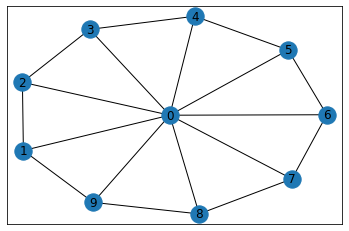

In [28]:
N = 10
G = nx.wheel_graph(N)
nx.is_connected(G)
nx.draw_networkx(G)

In [6]:
# Setup Models
base_model = Net()
models = {i : copy.deepcopy(base_model) for i in range(N)}

In [14]:
# Setup Data
data_split_type = "uniform"
labels = train_set.targets
train_idxs = np.arange(len(labels))
batch_size = 64

train_loaders = {}
train_iters = {}

if data_split_type == "hetero":
    for i in range(N):
        idx_to_keep = labels == i
        node_subset = torch.utils.data.Subset(train_set, train_idxs[idx_to_keep])
        train_loaders[i] = torch.utils.data.DataLoader(node_subset, batch_size=batch_size, shuffle=True)
        train_iters[i] = iter(train_loaders[i])
else:
    num_per = len(labels) / N
    splits = [int(num_per) for _ in range(N)]
    uniform_sets = torch.utils.data.random_split(train_set, splits)
    for i in range(N):
        train_loaders[i] = torch.utils.data.DataLoader(uniform_sets[i], batch_size=batch_size, shuffle=True)
        train_iters[i] = iter(train_loaders[i])

In [15]:
def primal_update(data_loader, data_iter, model, base_loss, dual, thj, rho, lr, max_its):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for k in range(max_its):
        # Load the batch
        try:
            x, y = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            x, y = next(data_iter)
        
        opt.zero_grad()
        
        yh = model.forward(x)
        
        # Compose CADMM Loss
        th = torch.nn.utils.parameters_to_vector(model.parameters())
        reg = torch.sum(torch.square(torch.cdist(th.reshape(1, -1), thj)))
        loss = base_loss(yh, y) + torch.dot(th, dual) + rho * reg

        # Backprop and step
        loss.backward()
        opt.step()

def validate(base_loss, val_loader, model):
    with torch.no_grad():
        loss = 0.0
        correct = 0
        for x, y in val_loader:
            yh = model.forward(x)
            loss += base_loss(yh, y).item()
            pred = yh.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
        avg_loss = loss / len(val_loader.dataset)
        acc = correct / len(val_loader.dataset)
        return avg_loss, acc

In [16]:
# Setup Loss and CADMM
primal_steps = 10
cadmm_iterations = 5
eval_every = 2
rho = 1.0
lr = 0.005

num_params = torch.nn.utils.parameters_to_vector(models[0].parameters()).shape[0]

duals = {i : torch.zeros(num_params) for i in range(N)}
obvs = torch.zeros((cadmm_iterations // eval_every + 1, N))
accs = torch.zeros((cadmm_iterations // eval_every + 1, N))

cnt_evals = 0
for k in range(cadmm_iterations):
    ths = {i : (torch.nn.utils.parameters_to_vector(models[i].parameters()).clone().detach()) for i in range(N)}

    for i in range(N):
        # Communication
        neighs = list(G.neighbors(i))
        thj = torch.stack([ths[j] for j in neighs])

        # Update the dual var
        duals[i] += rho * torch.sum(ths[i] - thj, dim=0)

        # Primal Update
        # (data_loader, data_iter, model, base_loss, dual, thj, rho, lr, max_its)
        primal_update(train_loaders[i], train_iters[i], models[i], torch.nn.NLLLoss(), duals[i], thj, rho, lr, primal_steps)
        
        # Evaluate model on all classes
        if k % eval_every == 0 or k == cadmm_iterations - 1:
            obvs[cnt_evals, i], accs[cnt_evals, i]  = validate(torch.nn.NLLLoss(), val_loader, models[i])
            obv_str = "{:.4f}".format(obvs[cnt_evals, i].item())
            acc_str = "{:.4f}".format(accs[cnt_evals, i].item())
            print("Iteration: ", k, " | NLLLoss: ", obv_str, " | Acc: ", acc_str, " | Node: ", i)
            
    if k % eval_every == 0:
        cnt_evals += 1

Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.2484  | Node:  0
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.1541  | Node:  1
Iteration:  0  | NLLLoss:  0.0018  | Acc:  0.5103  | Node:  2
Iteration:  0  | NLLLoss:  0.0023  | Acc:  0.0925  | Node:  3
Iteration:  0  | NLLLoss:  0.0021  | Acc:  0.2879  | Node:  4
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.2210  | Node:  5
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.1254  | Node:  6
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.2433  | Node:  7
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.2776  | Node:  8
Iteration:  0  | NLLLoss:  0.0022  | Acc:  0.2495  | Node:  9
Iteration:  2  | NLLLoss:  0.0020  | Acc:  0.3374  | Node:  0
Iteration:  2  | NLLLoss:  0.0020  | Acc:  0.3037  | Node:  1
Iteration:  2  | NLLLoss:  0.0015  | Acc:  0.6365  | Node:  2
Iteration:  2  | NLLLoss:  0.0021  | Acc:  0.1329  | Node:  3
Iteration:  2  | NLLLoss:  0.0020  | Acc:  0.3915  | Node:  4
Iteration:  2  | NLLLoss:  0.0021  | Acc:  0.2354  | Node:  5
Iteratio

Text(0, 0.5, 'Validation Accuracy')

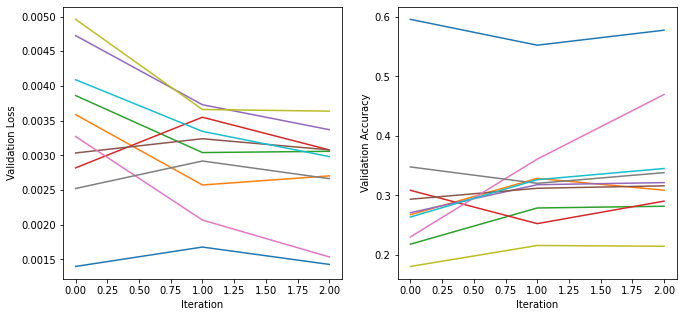

In [51]:
# Load data from Bespin runs
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
ax0.plot(obvs)
ax0.set_xlabel("Iteration")
ax0.set_ylabel("Validation Loss")
ax1.plot(accs)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Validation Accuracy")

In [55]:
torch.save({"obj_vals" : obvs, "accuracy" : accs}, "outputs/dist_class_results.pt")